# 2. U-Net Model Training for Building Segmentation

This notebook focuses on building, training, and evaluating the U-Net model for our building segmentation task.

**Workflow:**
1.  Load the preprocessed data from the `.npy` files.
2.  Define the U-Net model architecture.
3.  Compile and train the model.
4.  Evaluate the model's performance and visualize the results.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

%matplotlib inline

## 2.1. Load Preprocessed Data

We'll load the NumPy arrays that were created in the previous notebook.

In [2]:
PROCESSED_DATA_PATH = '../data/processed/'

X_train = np.load(os.path.join(PROCESSED_DATA_PATH, 'X_train.npy'))
Y_train = np.load(os.path.join(PROCESSED_DATA_PATH, 'Y_train.npy'))

X_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'X_test.npy'))
Y_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'Y_test.npy'))

print("Data loaded successfully.")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

Data loaded successfully.
X_train shape: (70, 128, 128, 3)
Y_train shape: (70, 128, 128, 1)


## 2.2. Build the U-Net Model

Here, we define the U-Net architecture. The model consists of an encoder (down-sampling path) to capture context and a decoder (up-sampling path) to enable precise localization. Skip connections are used to merge feature maps from the encoder to the decoder.

In [3]:
def build_unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder (Down-sampling path)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.25)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.25)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.5)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Decoder (Up-sampling path)
    u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(c3)
    u4 = Concatenate()([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
    c4 = Dropout(0.5)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(c4)
    u5 = Concatenate()([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the model
input_shape = (128, 128, 3)
model = build_unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

## 2.3. Train the Model

Now we train the model using the preprocessed training data (`X_train`, `Y_train`) and validate it on the test data.

In [4]:
# Define callbacks (optional but recommended)
# This will save the best model based on validation loss.
MODEL_SAVE_PATH = '../saved_models/unet_building_segmentation.h5'
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH, save_best_only=True, monitor='val_loss')
]

# Train the model
# Using a portion of the training data for validation within the fit method itself.
history = model.fit(
    X_train,
    Y_train,
    batch_size=16,
    epochs=25,  # We use EarlyStopping, so it might stop before 25 epochs
    validation_data=(X_test, Y_test),
    callbacks=callbacks
)

Epoch 1/25
5/5 [==============================] - 4s 706ms/step - loss: 1.5572 - accuracy: 0.6386 - val_loss: 0.5678 - val_accuracy: 0.7671
Epoch 2/25
5/5 [==============================] - 5s 1s/step - loss: 0.6618 - accuracy: 0.6984 - val_loss: 0.6732 - val_accuracy: 0.6844
Epoch 3/25
5/5 [==============================] - 10s 2s/step - loss: 0.6262 - accuracy: 0.7036 - val_loss: 0.5759 - val_accuracy: 0.7675
Epoch 4/25
5/5 [==============================] - 7s 1s/step - loss: 0.6047 - accuracy: 0.7611 - val_loss: 0.5527 - val_accuracy: 0.7678
Epoch 5/25
5/5 [==============================] - 6s 1s/step - loss: 0.5530 - accuracy: 0.7736 - val_loss: 0.4683 - val_accuracy: 0.7685
Epoch 6/25
5/5 [==============================] - 7s 1s/step - loss: 0.5119 - accuracy: 0.7843 - val_loss: 0.4769 - val_accuracy: 0.7694
Epoch 7/25
5/5 [==============================] - 7s 1s/step - loss: 0.4851 - accuracy: 0.7855 - val_loss: 0.4249 - val_accuracy: 0.7700
Epoch 8/25
5/5 [=====================

## 2.4. Evaluate Model Performance

Let's plot the training and validation accuracy and loss to visualize the model's performance over epochs.

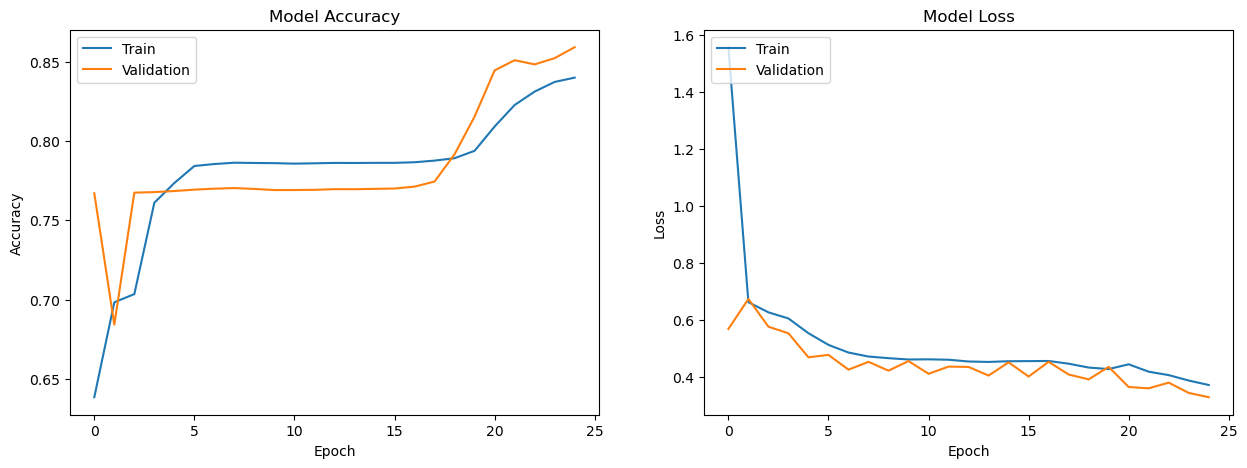

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

## 2.5. Visualize Predictions

Finally, let's load our best saved model and use it to make predictions on the test set. We will visualize a few examples to see how well our model performs.

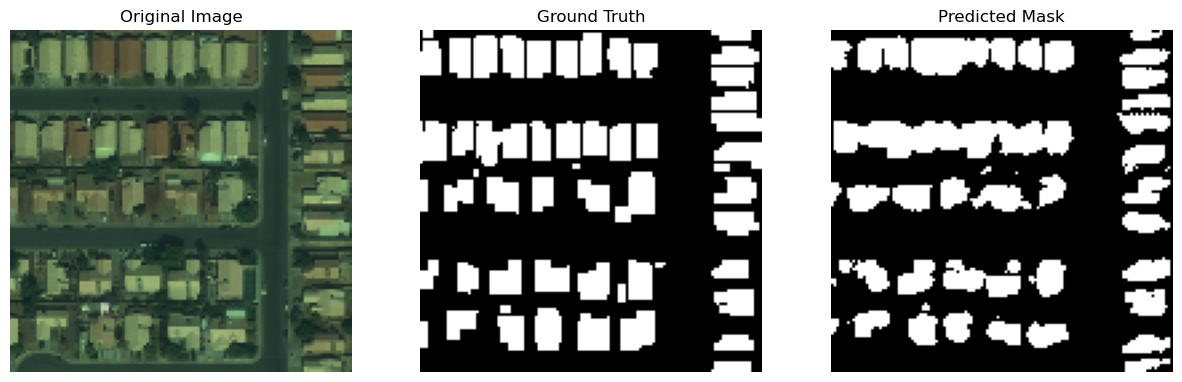

In [6]:
# Load the best model saved by our callback
model.load_weights(MODEL_SAVE_PATH)

# Make predictions on the test set
preds_test = model.predict(X_test)

# Apply a threshold to get binary masks
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Visualize a few random predictions
ix = np.random.randint(0, len(X_test))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
ax[0].imshow(X_test[ix])
ax[0].set_title('Original Image')
ax[0].axis('off')

# Ground Truth Mask
ax[1].imshow(np.squeeze(Y_test[ix]), cmap='gray')
ax[1].set_title('Ground Truth')
ax[1].axis('off')

# Predicted Mask
ax[2].imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

plt.show()